In [1]:
###Import required packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [7]:
###Specify if figures are to be saved to PNG
save_figs = True

###Color palette - order tuned manually
orders = ['N-A1-N', 'R2-R2-A1', 'R2-N-A2', 'N-N-N', 'N-A1-A2', 'R1-R2-A2',
       'R2-A1-A2', 'N-N-A2', 'R1-A1-N', 'N-A1-A1', 'N-R2-A1', 'N-N-A1',
       'N-R2-N', 'R1-R2-N', 'R1-A1-A2', 'R2-N-A1', 'R2-N-N', 'R1-N-N',
       'R1-N-A2', 'R2-A1-A1', 'R2-A1-N', 'R2-R2-N', 'N-R2-A2', 'R2-R2-A2',
       'R1-A1-A1', 'R1-R2-A1']
palette = {}
pal = sns.color_palette('Spectral', len(orders))
for i in range(len(orders)):
    palette[orders[i]] = pal[i]

###Helper functions for naming
def name_converter(A):
    name = ''
    for i in range(3):
        arch = A[i]
        if arch == (1, 0, 0, 0, 0):
            name += 'A1'
        elif arch == (0, 1, 0, 0, 0):
            name += 'A2'
        elif arch == (0, 0, 1, 0, 0):
            name += 'R1'
        elif arch == (0, 0, 0, 1, 0):
            name += 'R2'
        elif arch == (0, 0, 0, 0, 1):
            name += 'N'
        name += '-'
    return name[:-1]

def name_converter_str(A):
    name = ''
    for i in range(3):
        arch = A[i]
        if arch == '(1, 0, 0, 0, 0)':
            name += 'A1'
        elif arch == '(0, 1, 0, 0, 0)':
            name += 'A2'
        elif arch == '(0, 0, 1, 0, 0)':
            name += 'R1'
        elif arch == '(0, 0, 0, 1, 0)':
            name += 'R2'
        elif arch == '(0, 0, 0, 0, 1)':
            name += 'N'
        name += '-'
    return name[:-1]

/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/matplotlib/transforms.py:740: UserWarning: Warning: converting a masked element to nan.
  points = np.asarray(points, float)


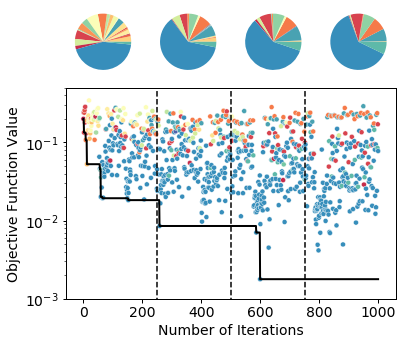

In [9]:
###FIGURE: Sample results
landscape = pd.read_csv('../data/p_aminostyrene_sample_run.csv')
landscape['Circuit'] = [name_converter_str([landscape.circuit[i][1:16], landscape.circuit[i][18:33], landscape.circuit[i][35:50]]) for i in range(len(landscape))]
landscape['Best Circuit'] = [name_converter_str([landscape.best_loss_circuit[i][1:16], landscape.best_loss_circuit[i][18:33], landscape.best_loss_circuit[i][35:50]]) for i in range(len(landscape))]
landscape = landscape.reset_index()

fig = plt.figure(figsize=(5.71, 4.9))
gs = gridspec.GridSpec(nrows=2, ncols=4, height_ratios=[1, 3], width_ratios=[1, 1, 1, 1])

ax = fig.add_subplot(gs[1, :])

ax.plot(landscape.index, landscape.best_losses, color='black', linewidth=2)
ax.set_ylabel('Objective Function Value', fontsize=14)
ax.set_yscale('log')
ax.set_xlabel('Number of Iterations', fontsize=14)
sns.scatterplot(x='index', y='loss', hue='Circuit', data=landscape, ax=ax, palette=palette, hue_order=orders, legend=False, s=25)
ax.set_ylim([10E-4, 5E-1])
ax.vlines(250, 0, 10E9, linestyles='dashed')
ax.vlines(500, 0, 10E9, linestyles='dashed')
ax.vlines(750, 0, 10E9, linestyles='dashed')

ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)
ax.tick_params(width=1)

quarter1 = (landscape.iloc[0:250].sort_values(by='Circuit').groupby('Circuit').count().loss/100).reset_index()
quarter2 = (landscape.iloc[250:500].sort_values(by='Circuit').groupby('Circuit').count().loss/100).reset_index()
quarter3 = (landscape.iloc[500:750].sort_values(by='Circuit').groupby('Circuit').count().loss/100).reset_index()
quarter4 = (landscape.iloc[750:1000].sort_values(by='Circuit').groupby('Circuit').count().loss/100).reset_index()

ax = fig.add_subplot(gs[0, 0])
ax.pie(quarter1.loss, colors=[palette[a] for a in quarter1.Circuit.unique().tolist()])

ax = fig.add_subplot(gs[0, 1])
ax.pie(quarter2.loss, colors=[palette[a] for a in quarter2.Circuit.unique().tolist()])

ax = fig.add_subplot(gs[0, 2])
ax.pie(quarter3.loss, colors=[palette[a] for a in quarter3.Circuit.unique().tolist()])

ax = fig.add_subplot(gs[0, 3])
ax.pie(quarter4.loss, colors=[palette[a] for a in quarter4.Circuit.unique().tolist()])


fig.tight_layout()# 
if save_figs: fig.savefig('../figs/p_aminostyrene_sample_run.png', dpi=300)

In [10]:
#Filter experiment results for ODE errors
total_landscape = pd.read_csv('../data/p_aminostyrene_chemical_robustness.csv').reset_index()
total_background = pd.read_csv('../data/p_aminostyrene_background.csv')
#Recompute best loss on non-error samples
start=0
stop=1000
new_total_landscape = pd.DataFrame()
for j in range(100):
    landscape = total_landscape.iloc[start:stop].reset_index(drop=True)
    best_loss = 1E5
    best_circuit = 'Initial'
    best_losses = []
    best_losses_circuits = []
    for i in range(len(landscape)):
        if landscape.loss[i] < best_loss and landscape.loss[i] != 0:
            best_loss = landscape.loss[i]
            best_circuit = landscape.circuit[i]
        best_losses.append(best_loss)
        best_losses_circuits.append(best_circuit)
    landscape['best_losses'] = best_losses
    landscape['best_loss_circuit'] = best_losses_circuits 
    new_total_landscape = pd.concat([new_total_landscape, landscape])
    start = stop
    stop += 1000
new_total_landscape = new_total_landscape.loc[new_total_landscape.loss != 0]

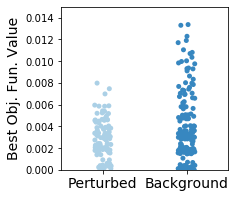

In [16]:
###FIGURE: Chemical robustness
plot_landscape = new_total_landscape.loc[new_total_landscape.index==999]

plot_data = pd.DataFrame({'best_loss': plot_landscape.best_losses.to_list(), 'type':'Perturbed'})
plot_data = pd.concat([plot_data, pd.DataFrame({'best_loss':total_background.loc[total_background['index'] == 999].best_losses.to_list(), 'type':'Background' })])
fig, ax = plt.subplots(1,1,figsize=(3, 3))
sns.stripplot(data=plot_data, y='best_loss', x='type', palette='Blues', ax=ax)
ax.set_ylabel('Best Obj. Fun. Value', fontsize=14)
ax.set_xlabel('')
ax.set_ylim([0, 0.015])
ax.tick_params(axis='x', labelsize=14)
if save_figs: fig.savefig('../figs/p_aminostyrene_objective_fn_strip.png', dpi=300)

In [12]:
## Run PCA and T-SNE
features = ['theta_paf_prom1', 'theta_paf_prom2', 'theta_paf_prom3', 'theta_paca_prom1',
       'theta_paca_prom2', 'theta_paca_prom3', 'k_paf_papA', 'k_paf_papB',
       'k_paf_papC', 'k_paf_prom2', 'k_paf_prom3', 'k_paca_papA',
       'k_paca_papB', 'k_paca_papC', 'k_paca_prom2', 'k_paca_prom3']
background = total_background.loc[total_background['index'] == 999]
background['perturbed'] = [False for i in range(len(background))]
perturbed = plot_landscape
perturbed['perturbed'] =  [True for i in range(len(perturbed))]
combined = pd.concat([background, perturbed])
x = combined.loc[:, features].values
#Normalize features
x = StandardScaler().fit_transform(x)
#Run PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])
combined['pc1'] = principalComponents[:,0]
combined['pc2'] = principalComponents[:,1]

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, init='pca')
tsne_results = tsne.fit_transform(x)
combined['tsne1'] = tsne_results[:,0]
combined['tsne2'] = tsne_results[:,1]

perturbed = combined.loc[combined.perturbed == True].sort_values(by='Circuit').reset_index(drop=True)
background = combined.loc[combined.perturbed == False].sort_values(by='Circuit').reset_index(drop=True)

/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_87792/3546506786.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  background['perturbed'] = [False for i in range(len(background))]
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_87792/3546506786.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perturbed['perturbed'] =  [True for i in range(len(perturbed))]
/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The de

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 300 samples in 0.000s...
[t-SNE] Computed neighbors for 300 samples in 0.049s...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 1.797530
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.673172
[t-SNE] KL divergence after 300 iterations: 1.523066


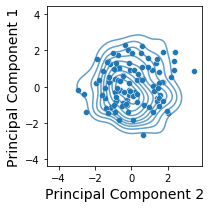

In [13]:
### Figure: PCA results
fig, axs = plt.subplots(1,1,figsize=(3,3))
ax = axs
sns.scatterplot(x="pc1", y="pc2", data=perturbed, ax=ax, legend=False)
sns.kdeplot(data=background, x="pc1", y="pc2", thresh=.1, ax=ax, alpha=0.7, legend=False)
ax.set_ylabel('Principal Component 1', fontsize=14)
ax.set_xlabel('Principal Component 2', fontsize=14)
fig.tight_layout()
if save_figs: fig.savefig('../figs/p_aminostyrene_parameter_pca.png', dpi=300)